<a href="https://colab.research.google.com/github/NickuFeng/Capstone-Project/blob/main/3_Plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This notebook demonstrates the analysis part of this project. The goal is to compare the two model's prediction with each other, and with the true observed value that is avaliable from Geuvadis dataset.  

### Major Steps

- Set up the environment
- Import true observations from Geuvadis
- Import predictions made by Predixcan
- Make Plots and tables 


## Set up environment

In [ ]:
import pandas as pd # for manipulating dataframes
import numpy as np # for numerical computations
import matplotlib.pyplot as plt # for plotting
import matplotlib as mpl # for plotting
import seaborn as sns # for plotting
import os, sys # functions for interacting with the operating system
import random  

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read in the GEUVADIS true observations and Predixcan predictions.

In [ ]:
geuvadis_gene_expression = pd.read_table('https://uchicago.box.com/shared/static/5vwc7pjw9qmtv7298c4rc7bcuicoyemt.gz', sep='\t', index_col='gene_name',
                                         dtype={'gene_id': str, 'gene_name':str, 'TargetID':str, 'Chr':str})

In [ ]:
predixcan_gene_expression = pd.read_table('https://uchicago.box.com/shared/static/4k68u7x7rxjpoljfdva6qipjxwzd3l0g.txt', sep=' ', index_col='gene_name')

## Get ready to make plots

Read in the result we generated from the previous script. Becuase its index is the individuals that we are interested, we can use them as the key to obtain the desired information from Geuvadis dataset and PredixCan database.

In [ ]:
path1 = "/content/drive/MyDrive/Capstone_Project_2022/results/CEU_Haplotype_Sum.csv"
Enformer_CEU = pd.read_csv(path1, index_col= 'Unnamed: 0')

In [ ]:
path2 = "/content/drive/MyDrive/Capstone_Project_2022/results/YRI_Haplotype_Sum.csv"
Enformer_YRI = pd.read_csv(path2, index_col= 'Unnamed: 0')

The index of these two csv files are the list of the selected individuals, and the columns are the list of the target genes.

In [ ]:
YRI_individual = Enformer_YRI.index.values.tolist()
CEU_individual = Enformer_CEU.index.values.tolist()
list_of_genes = Enformer_CEU.columns.tolist()

Use the individual and the gene as reference to locate the true observation from Geuvadis dataset, and the prediction made by another deep learning method 'PrediXcan'.

In [ ]:
GEU_YRI = pd.DataFrame()
predixcan_YRI = pd.DataFrame()
for gene in range(len(list_of_genes)):
  for individual in range(len(YRI_individual)):
    GEU_YRI.at[YRI_individual[individual],list_of_genes[gene]] = geuvadis_gene_expression.loc[list_of_genes[gene],YRI_individual[individual]]
    predixcan_YRI.at[YRI_individual[individual],list_of_genes[gene]] = predixcan_gene_expression.loc[list_of_genes[gene],YRI_individual[individual]]

In [ ]:
GEU_CEU = pd.DataFrame()
predixcan_CEU=pd.DataFrame()
for gene in range(len(list_of_genes)):
  for individual in range(len(CEU_individual)):
    GEU_CEU.at[CEU_individual[individual],list_of_genes[gene]] = geuvadis_gene_expression.loc[list_of_genes[gene],CEU_individual[individual]]
    predixcan_CEU.at[CEU_individual[individual],list_of_genes[gene]] = predixcan_gene_expression.loc[list_of_genes[gene],CEU_individual[individual]]

In [ ]:
# Making sure we save the file.
if not os.path.exists('/content/drive/MyDrive/Capstone_Project_2022/results/Geuvadis_YRI.csv'):
  GEU_YRI.to_csv('/content/drive/MyDrive/Capstone_Project_2022/results/Geuvadis_YRI.csv')

if not os.path.exists('/content/drive/MyDrive/Capstone_Project_2022/results/predixcan_YRI.csv'):
  predixcan_YRI.to_csv('/content/drive/MyDrive/Capstone_Project_2022/results/predixcan_YRI.csv')

if not os.path.exists('/content/drive/MyDrive/Capstone_Project_2022/results/Geuvadis_CEU.csv'):
  GEU_CEU.to_csv('/content/drive/MyDrive/Capstone_Project_2022/results/Geuvadis_CEU.csv')
  
if not os.path.exists('/content/drive/MyDrive/Capstone_Project_2022/results/predixcan_CEU.csv'):
  predixcan_CEU.to_csv('/content/drive/MyDrive/Capstone_Project_2022/results/predixcan_CEU.csv')

# Define Plotting Functions

Now we have everything we want, true observations from Geuvadis, predictions made by Enformer, and predictions made by PredixCan. Let's make some plots!

We want to make the following three types of plots:
1. Predixcan vs. Geuvadis
2. Enformer vs. Geuvadis
3. Predixcan vs. Enformer

### Code for plotting

We first define a function to help us plotting.

In [ ]:
def plot_one_vs_two(interested_gene, interested_individuals, gene_expression_1, expression_1_name:str, gene_expression_2, expression_2_name:str, group_tag:str, color:str):
  '''
  First two parameters are self-explainatory. The next two pairs of parameters are gene expression and its name. 
  group_tag is used for the plot, file path, and image generating process. color determines the color of the graph.
  
  This function will concat the two series, give them proper column names. Then show a plot and return correlation coefficient
  '''
  # concatenate both geuvadis_expression and predixcan_expression
  df = pd.concat([gene_expression_1, gene_expression_2], axis=1)
  df.columns=[expression_1_name, expression_2_name]

  # path
  filepath='/content/drive/MyDrive/Capstone_Project_2022/results/' + expression_1_name + '_vs_' + expression_2_name + '_plot'+'_'+group_tag
  if not os.path.exists(filepath):
    !mkdir -p $filepath # create a folder to store the following series of plots

  # correlation coefficient between the two columns
  corr_coef=df[expression_1_name].corr(df[expression_2_name])

  # plotting and adding title, label
  plot=sns.regplot(x=df[expression_1_name], y=df[expression_2_name], color=color)
  plot.set(title='{} vs. {} predictions on {} individuals from {} sample for gene {}'.format(expression_1_name, expression_2_name, len(interested_individuals), group_tag, interested_gene))
  
  text="The corr.coef is: {:.6f}".format(corr_coef)

  fig = plot.get_figure()
  # save image
  fig.savefig(fname=filepath+"/"+expression_1_name+ "_vs_" +expression_2_name +'_'+ group_tag+'_'+interested_gene+'.png', bbox_inches='tight')

  return corr_coef

# Making Plots and Correlation Tables

Scripts below generate the desired plots that we want. 

In case you do not wish to store all the plots, or only want to store some of them. You can modify the plotting function by commenting out the **fig.savefig** line.

You can also chose your own range of genes by editing the **list_of_genes** below.

Notice the plotting function calculates the pearson correlation everytime and returns that value. We make use of that and store it in a table.

### Geuvadis vs PredixCan

Geuvadis vs PredixCan on **CEU sample group**




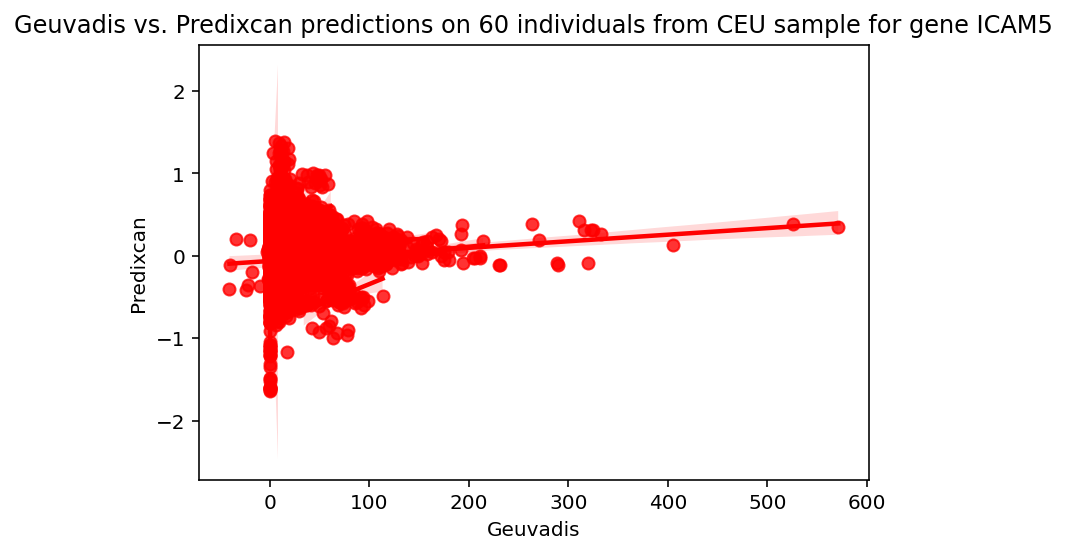

In [ ]:
# Create a dataframe to store coef
Geu_Pre_CEU_coef=pd.DataFrame(index=list_of_genes, columns=['Correlation Coefficient'])

# Generating and storing plots for PrediXcan vs Geuvadis on the CEU sample group, store corr_coef along the way
for gene in range(len(list_of_genes)):
  GC=GEU_CEU[list_of_genes[gene]] #interested gene expression of Geuvadis
  PC=predixcan_CEU[list_of_genes[gene]] #interested gene expression of Predixcan
  coef=plot_one_vs_two(interested_gene=list_of_genes[gene], interested_individuals=CEU_individual, gene_expression_1=GC, expression_1_name='Geuvadis', 
                     gene_expression_2=PC, expression_2_name='Predixcan', group_tag='CEU', color='red')
  Geu_Pre_CEU_coef.loc[list_of_genes[gene]] = coef

Geuvadis vs PredixCan on **YRI sample group**

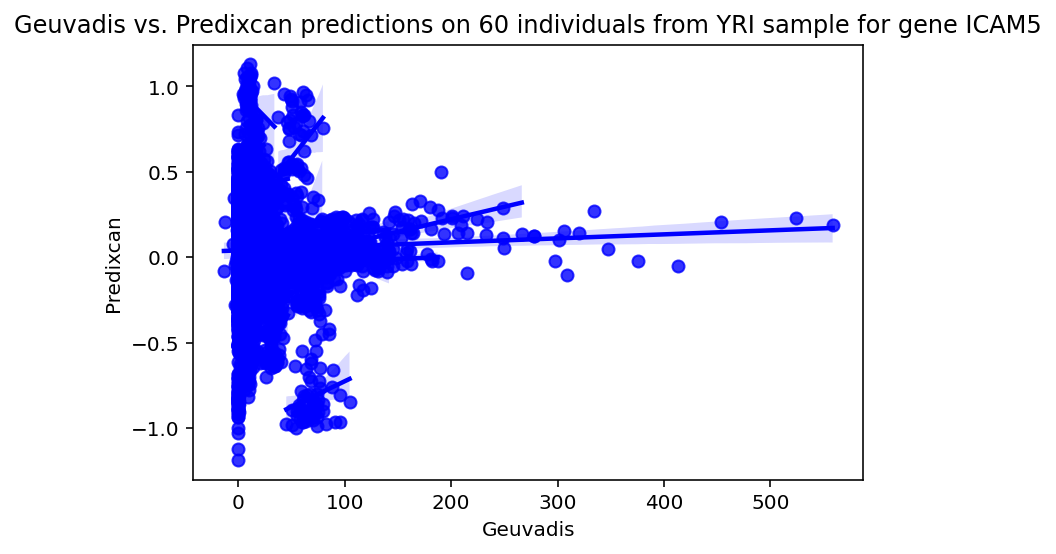

In [ ]:
# Create a dataframe to store coef
Geu_Pre_YRI_coef=pd.DataFrame(index=list_of_genes, columns=['Correlation Coefficient'])

# Generating and storing plots for PrediXcan vs Geuvadis on the YRI sample group, store corr_coef along the way
for gene in range(len(list_of_genes)):
  GY=GEU_YRI[list_of_genes[gene]]
  PY=predixcan_YRI[list_of_genes[gene]]
  coef=plot_one_vs_two(interested_gene=list_of_genes[gene], interested_individuals=YRI_individual, gene_expression_1=GY, expression_1_name='Geuvadis', 
                     gene_expression_2=PY, expression_2_name='Predixcan', group_tag='YRI', color='blue')
  Geu_Pre_YRI_coef.loc[list_of_genes[gene]] = coef

### Enformer vs Geuvadis Plotting


CEU group

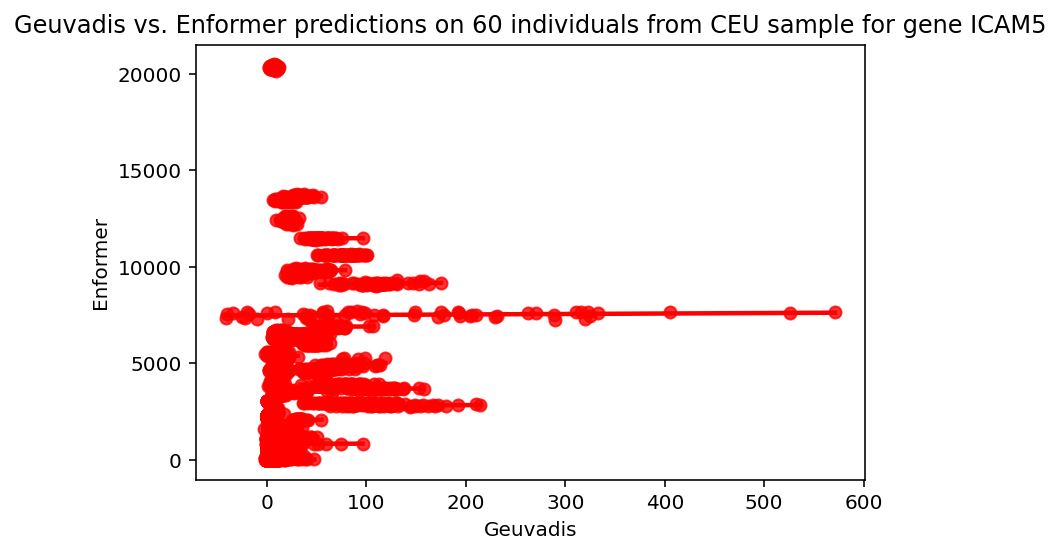

In [ ]:
# Create a dataframe to store coef
Geu_Enf_CEU_coef=pd.DataFrame(index=list_of_genes, columns=['Correlation Coefficient'])

# Generating and storing plots for Enformer vs Geuvadis on the CEU sample group, store corr_coef along the way
for gene in range(len(list_of_genes)):
  GC=GEU_CEU[list_of_genes[gene]]
  EC=Enformer_CEU[list_of_genes[gene]]
  coef=plot_one_vs_two(interested_gene=list_of_genes[gene], interested_individuals=CEU_individual, gene_expression_1=GC, expression_1_name='Geuvadis', 
                     gene_expression_2=EC, expression_2_name='Enformer', group_tag='CEU', color='red')
  Geu_Enf_CEU_coef.loc[list_of_genes[gene]] = coef

**YRI group**

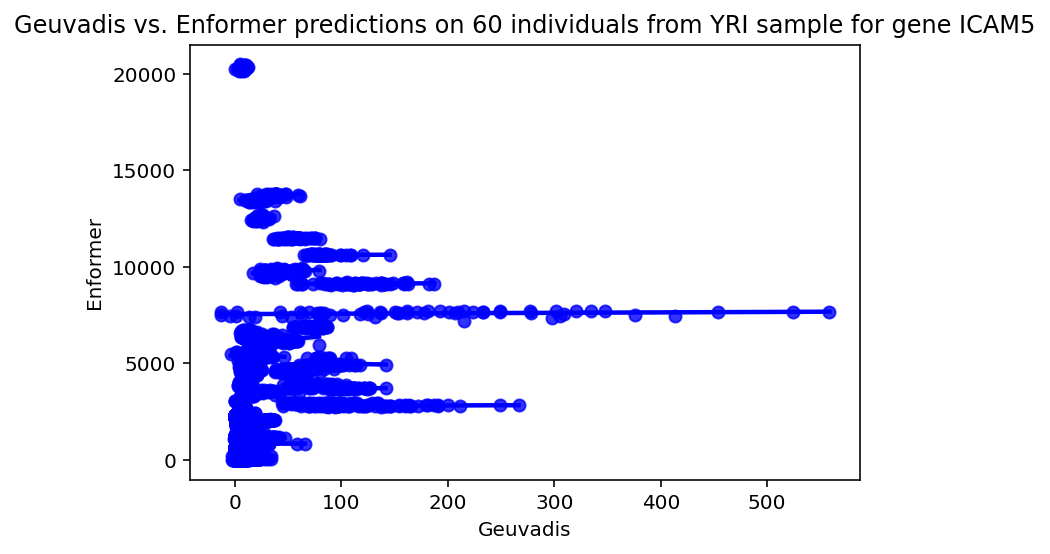

In [ ]:
# Create a dataframe to store coef
Geu_Enf_YRI_coef=pd.DataFrame(index=list_of_genes, columns=['Correlation Coefficient'])

# Generating and storing plots for Enformer vs Geuvadis on the CEU sample group, store corr_coef along the way
for gene in range(len(list_of_genes)):
  GY=GEU_YRI[list_of_genes[gene]]
  EY=Enformer_YRI[list_of_genes[gene]]
  coef=plot_one_vs_two(interested_gene=list_of_genes[gene], interested_individuals=YRI_individual, gene_expression_1=GY, expression_1_name='Geuvadis', 
                     gene_expression_2=EY, expression_2_name='Enformer', group_tag='YRI', color='blue')
  Geu_Enf_YRI_coef.loc[list_of_genes[gene]] = coef

### Enformer vs Predixcan

##### CEU Group

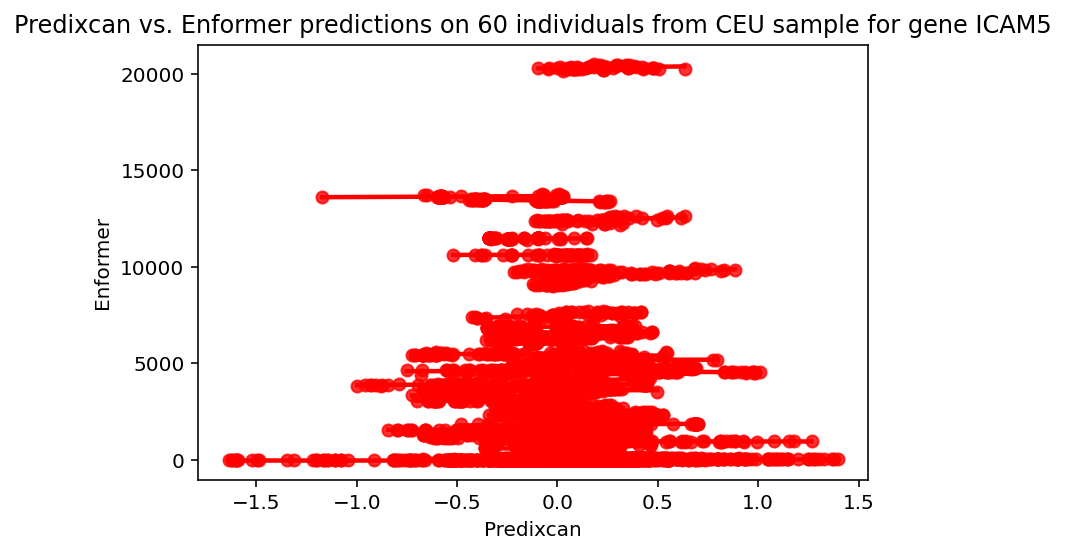

In [ ]:
# Create a dataframe to store coef
Enf_Pre_CEU_coef=pd.DataFrame(index=list_of_genes, columns=['Correlation Coefficient'])

# Generating and storing plots for Enformer vs Predixcan on the CEU sample group, store corr_coef along the way
for gene in range(len(list_of_genes)):
  PC=predixcan_CEU[list_of_genes[gene]]
  EC=Enformer_CEU[list_of_genes[gene]]
  coef=plot_one_vs_two(interested_gene=list_of_genes[gene], interested_individuals=YRI_individual, gene_expression_1=PC, expression_1_name='Predixcan', 
                     gene_expression_2=EC, expression_2_name='Enformer', group_tag='CEU', color='red')
  Enf_Pre_CEU_coef.loc[list_of_genes[gene]] = coef

##### YRI Group

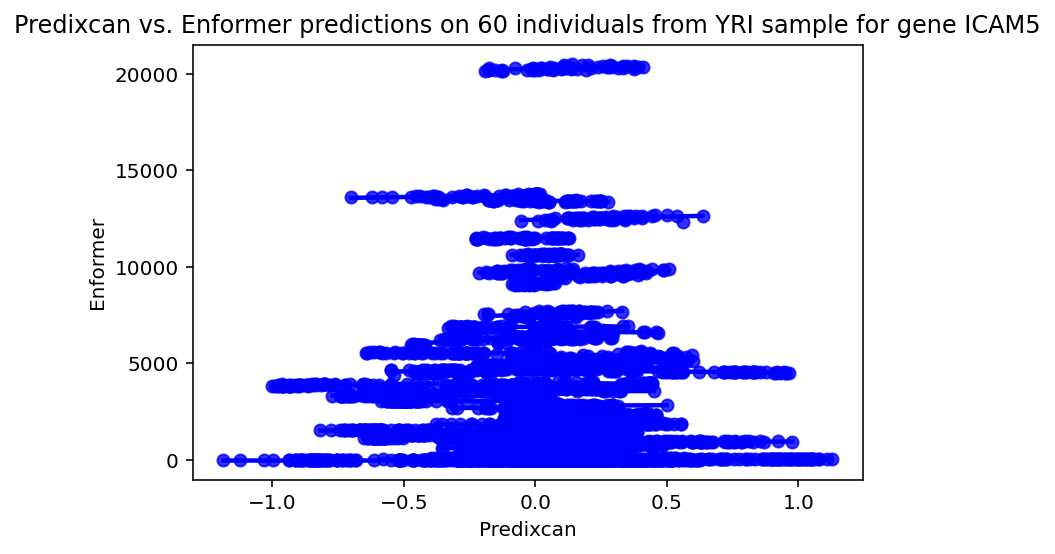

In [ ]:
# Create a dataframe to store coef
Enf_Pre_YRI_coef=pd.DataFrame(index=list_of_genes, columns=['Correlation Coefficient'])

# Generating and storing plots for Enformer vs Geuvadis on the CEU sample group, store corr_coef along the way
for gene in range(len(list_of_genes)):
  PY=predixcan_YRI[list_of_genes[gene]]
  EY=Enformer_YRI[list_of_genes[gene]]
  coef=plot_one_vs_two(interested_gene=list_of_genes[gene], interested_individuals=YRI_individual, gene_expression_1=PY, expression_1_name='Predixcan', 
                     gene_expression_2=EY, expression_2_name='Enformer', group_tag='YRI', color='blue')
  Enf_Pre_YRI_coef.loc[list_of_genes[gene]] = coef

## Correlation Tables

In the process above we have stored the correlation coefficient everytime when we plot one gene expression measurement against another. But remember out goal is to compare each model's predicting performance on target genes across population. 



 Thus, our last step of this script is to integrate these tables. We will have two correlation tables for each group of individuals representing their ancestry, CEU for European ancestry and YRI for African ancestry. These two correlation tables. Each row is the pearson correlation of the model's prediction against the Geuvadis observed value on a specefic gene across the sample group.

In [ ]:
YRI_corr = pd.concat([Geu_Pre_YRI_coef, Geu_Enf_YRI_coef], axis=1)
YRI_corr.columns=['Predixcan','Enformer']

CEU_corr = pd.concat([Geu_Pre_CEU_coef, Geu_Enf_CEU_coef], axis=1)
CEU_corr.columns=['Predixcan','Enformer']

## Add strand information 

We observed there are some funny behavior with Enformer's prediction, that its result cause the corr.coef to **flip the sign**. This is very obvious if you look at the correlation table thoroughly, that sometimes Predixcan and Enformer have relatively same corr.coef except Enformer's has the opposite sign. 

---

Therefore we have decided to add the strand information of the target gene into the table and see if that helps to explain this weird behavior of Enformer's.

In [ ]:
df_full_target_genes = pd.read_csv('/content/drive/MyDrive/Capstone_Project_2022/data/target_gene_info.csv', index_col = 'Unnamed: 0')

In [ ]:
# only run this once
# YRI_corr["strand"] = " "
# CEU_corr["strand"] = " "

In [ ]:
if 'strand' in YRI_corr.columns:
    print("We have strand column already, no need to create another one")
else:
    YRI_corr["strand"] = " "

In [ ]:
if 'strand' in CEU_corr.columns:
    print("We have strand column already, no need to create another one")
else:
    CEU_corr["strand"] = " "

In [ ]:
for index, row in df_full_target_genes.iterrows():
    chr = str(row['chr'])
    df = pd.read_table('/content/drive/MyDrive/Capstone_Project_2022/data/tss_by_chr/chr' +str(chr)+ '_tss_by_gene.txt', sep='\t')
    del df['txStart_Sites']
    df=df.set_index('genes')
    gene = str(row['gene_name'])
    df_strand=df.loc[[gene]]
    YRI_corr.at[gene,'strand']=df_strand.loc[gene].values
    CEU_corr.at[gene,'strand']=df_strand.loc[gene].values

In [ ]:
YRI_corr.head(3)

,Predixcan,Enformer,strand
SERPINB1,0.156383,-0.067964,[-]
KBTBD2,-0.147582,0.1334,[-]
GCDH,-0.009475,-0.183083,[+]


In [ ]:
CEU_corr.head(3)

,Predixcan,Enformer,strand
SERPINB1,0.484646,-0.133755,[-]
KBTBD2,0.148262,-0.140681,[-]
GCDH,0.217796,0.197588,[+]


In [ ]:
# Store the results if we have not yet
if not os.path.exists('/content/drive/MyDrive/Capstone_Project_2022/results/Pre_Enf_YRI.csv'):
  YRI_corr.to_csv("/content/drive/MyDrive/Capstone_Project_2022/results/Pre_Enf_YRI_correlation_table.csv")
if not os.path.exists('/content/drive/MyDrive/Capstone_Project_2022/results/Pre_Enf_CEU.csv'):
  CEU_corr.to_csv("/content/drive/MyDrive/Capstone_Project_2022/results/Pre_Enf_CEU_correlation_table.csv")

**Now we are ready to move on to the next and the final part of this project: Analysis!** 